## Get Data

In [8]:
import glob

list_of_files = glob.glob('/home/rakvat/mydev/nlp_experiments/scrape_anarchist_library/en/*.txt') 
documents = {}
for filename in list_of_files:
    content = []
    f = open(filename, 'r')
    for line in f:
        content.append(line)
    f.close()
    documents[filename.split('/')[-1]] = content

## Preprocess

In [44]:
import re # regex
import nltk
from nltk.corpus import stopwords
import nltk.data

data = []
for key, value in documents.items():
    document = {}
    first_line_without_meta = 0
    for i, line in enumerate(value[:15]):
        if line.startswith('#author'):
            document['author'] = line[8:-1]
        if line.startswith('#title'):
            document['title'] = line[7:-1]
        if line.startswith('#date'):
            match = re.search('(\d\d\d\d)', line[6:-1])
            if match:
                document['year'] = match.group(0)
        if first_line_without_meta == 0 and line[0] != '#':
            first_line_without_meta = i
    document['text'] = ''.join(value[first_line_without_meta:])
    document['text_len'] = len(document['text'])
    document['file'] = key
    
    data.append(document)
print('done: {}'.format(len(data)))

done: 3087


In [3]:
stopwords = ['em', '/em', '/quote', '*****', '****', '***', '**', "''", '``', 'br', '/strong', "\'s", "n\'t", '--', 
     'p.','<', '>', '?', '.', '“', '/sup', '”', '—', ',', '’', 't', 're', 's', 'll',':', '‘', 'i', '...', ';', 
     '(', ')', '[', ']']

texts = [t for t in map(lambda x: x['text'], data)]

document_sentences_lists = []
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

for text in texts:
    sentences = tokenizer.tokenize(text)
    text_sentences = []
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        words = [word.lower() for word in words]
        words = [word for word in words if word not in stopwords]
        words = [re.sub(r'\.$|\?$|!$', '', x) for x in words]
        text_sentences.append(words)
    document_sentences_lists.append(text_sentences)

print(document_sentences_lists[3][0:20])

[['there', 'are', 'some', 'ominous', 'disturbances', 'of', 'special', 'moment', 'in', 'the', 'labor', 'world'], ['at', 'new', 'orleans', 'the', 'street-car', 'men', 'are', 'engaged', 'in', 'a', 'desperate', 'struggle', 'and', 'according', 'to', 'the', 'capitalistic', 'press', 'some', 'rioting', 'has', 'occurred', 'the', 'strikers', 'it', 'is', 'said', 'having', 'fired', 'on', 'the', 'police'], ['the', 'granite', 'cutter', 'union', 'has', 'been', 'locked', 'out', 'by', 'the', 'bosses', 'union', 'who', 'are', 'engaged', 'in', 'an', 'effort', 'to', 'compel', 'the', 'cutters', 'to', 'change', 'the', 'time', 'of', 'signing', 'the', 'yearly', 'contract', 'from', 'january', 'to', 'january', 'instead', 'of', 'as', 'heretofore', 'from', 'may', 'to', 'may'], ['the', 'men', 'claim', 'that', 'this', 'would', 'give', 'the', 'bosses', 'an', 'increased', 'advantage', 'over', 'them', 'because', 'in', 'january', 'most', 'of', 'the', 'members', 'are', 'idle', 'and', 'would', 'be', 'compelled', 'to', 'ma

## Word2Vec

In [4]:
from gensim.models import Word2Vec
all_sentences = [sentence for ds in document_sentences_lists for sentence in ds]
word_2_vec_model = Word2Vec(sentences=all_sentences, size=100, window=5, min_count=5, workers=4, sg=0)

In [6]:
fname = '../data/word2vec_model'
word_2_vec_model.save(fname)
word_2_vec_model = Word2Vec.load(fname)

In [7]:
word_2_vec_model.wv.most_similar("anarchy")

[('anarchism', 0.6377719044685364),
 ('communism', 0.6196501851081848),
 ('utopia', 0.6009454727172852),
 ('communalism', 0.5833500027656555),
 ('primitivism', 0.5831833481788635),
 ('nihilism', 0.5738281011581421),
 ('leftism', 0.5688527226448059),
 ('statism', 0.5470791459083557),
 ('socialism', 0.5416628122329712),
 ('chaos', 0.534917950630188)]

In [8]:
word_2_vec_model.wv.most_similar(positive=['anarchy', 'peace', 'solidarity'], negative=['chaos'])

[('cooperation', 0.6655155420303345),
 ('self-determination', 0.6019327044487),
 ('co-operation', 0.5778247117996216),
 ('fraternity', 0.5762279033660889),
 ('equality', 0.5739743709564209),
 ('friendship', 0.5731697082519531),
 ('freedom', 0.5689136981964111),
 ('liberty', 0.556557834148407),
 ('association', 0.550492525100708),
 ('independence', 0.546848475933075)]

In [9]:
word_2_vec_model.wv.most_similar_cosmul(positive=['anarchy', 'peace', 'solidarity'], negative=['chaos'])

[('cooperation', 0.6891627311706543),
 ('self-determination', 0.649440586566925),
 ('association', 0.6177771091461182),
 ('fraternity', 0.6167409420013428),
 ('friendship', 0.6160852909088135),
 ('co-operation', 0.615831732749939),
 ('equality', 0.6143702268600464),
 ('freedom', 0.6077560782432556),
 ('independence', 0.6059341430664062),
 ('liberty', 0.604721188545227)]

In [10]:
word_2_vec_model.wv.most_similar_cosmul(positive=['economy', 'planning', 'solidarity'], negative=['central'])

[('cooperation', 0.699571430683136),
 ('co-operation', 0.6575556993484497),
 ('organization', 0.6111617088317871),
 ('coordination', 0.6032154560089111),
 ('adjustment', 0.5998144149780273),
 ('interdependence', 0.5972313284873962),
 ('relationships', 0.5946120619773865),
 ('organisation', 0.5903456807136536),
 ('environment', 0.586973249912262),
 ('co-ordination', 0.5867806673049927)]

In [11]:
word_2_vec_model.wv.similarity('war', 'peace')

0.35113674120785815

In [13]:
# this does not work because this word is not found. But it can be done with FastText (see below)
word_2_vec_model.wv.most_similar('computer-simulation')

KeyError: "word 'computer-simulation' not in vocabulary"

In [14]:
from gensim.models import FastText
fast_text_model = FastText(all_sentences, size=100, window=5, min_count=5, workers=4,sg=1)

In [15]:
fast_text_model.wv.most_similar('computer-simulation')

[('computerization', 0.8969423174858093),
 ('simulation', 0.8511350750923157),
 ('supercomputer', 0.8509286642074585),
 ('computerisation', 0.8417525291442871),
 ('computer', 0.8244168758392334),
 ('compute', 0.8173179626464844),
 ('computation', 0.8066041469573975),
 ('computer-based', 0.797387421131134),
 ('cybernetic', 0.7847089171409607),
 ('simulations', 0.7744627594947815)]

## Doc2Vec

In [2]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [16]:
document_words_list = []
for document_sentences in document_sentences_lists:
    document_words_list.append([word for sentence in document_sentences for word in sentence])
epochs = 100
documents = [TaggedDocument(document_words_list[index], [doc['file']]) for index, doc in enumerate(data)]

In [17]:
doc_2_vec_model = Doc2Vec(vector_size=300, window=8, min_count=5, workers=8, epochs=epochs)
doc_2_vec_model.build_vocab(documents)
doc_2_vec_model.train(documents, total_examples=doc_2_vec_model.corpus_count, epochs=epochs)

In [3]:
fname = '../data/doc2vec_model'
# doc_2_vec_model.save(fname)
doc_2_vec_model = Doc2Vec.load(fname)  # you can continue training with the loaded model!

In [4]:
doc_2_vec_model.wv.most_similar('anarchy')

[('anarchism', 0.47327348589897156),
 ('wildness', 0.32441815733909607),
 ('anarchist', 0.29785212874412537),
 ('freedom', 0.2870025634765625),
 ('chaos', 0.2846091091632843),
 ('liberty', 0.27407899498939514),
 ('fascism', 0.2703554332256317),
 ('1999–2000', 0.2646511197090149),
 ('kahn', 0.2616986036300659),
 ('prikaz', 0.25502756237983704)]

In [20]:
tokens = 'cybernetics'.split()
new_vector = doc_2_vec_model.infer_vector(tokens)
sims = doc_2_vec_model.docvecs.most_similar([new_vector])
sims

[('n1x-hello-from-the-wired.muse.txt', 0.32593950629234314),
 ('tiqqun-the-cybernetic-hypothesis.muse.txt', 0.3247065246105194),
 ('eli-maybell-limitations-of-leftism.muse.txt', 0.30816972255706787),
 ('david-watson-saturn-and-scientism.muse.txt', 0.30261483788490295),
 ('paul-rabin-computers-and-anarchism.muse.txt', 0.30069079995155334),
 ('lawrence-jarach-on-the-radical-virtues-of-being-left-alone-deconstructing-staudenmaier.muse.txt',
  0.2957090139389038),
 ('janet-biehl-theses-on-social-ecology-and-deep-ecology.muse.txt',
  0.2954569458961487),
 ('ted-kaczynski-answer-to-some-comments-made-in-green-anarchist.muse.txt',
  0.2953936755657196),
 ('john-brinker-mix-ted-kaczynski-with-lsd-do-you-get-the-unabomber.muse.txt',
  0.2926965355873108),
 ('savage-state-why-you-shouldn-t-call-the-police-pigs.muse.txt',
  0.2860642373561859)]

## Visualization

In [5]:
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.decomposition import PCA
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [22]:
doc_2_vec_model.docvecs[0].shape

(300,)

In [45]:
len(data)

3087

In [10]:
l = list(map(lambda x: doc_2_vec_model.docvecs[x], range(0,len(data))))
len(l)

3087

In [11]:
X = np.concatenate(l).reshape((len(l), 300))

In [12]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(X)
print(projected.shape)

(3087, 2)


Text(0,0.5,'component 2')

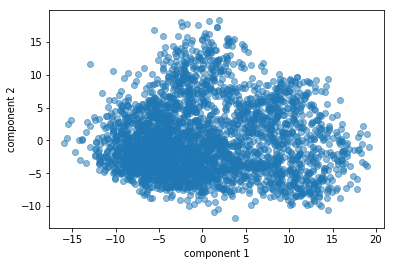

In [13]:
plt.scatter(projected[:, 0], projected[:, 1],
            alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')

In [39]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

labels = list(map(lambda x: data[x]['file'], range(0, len(data))))
labels[0]

'yves-coleman-french-banlieues-and-urban-guerrillas.muse.txt'

In [46]:
texts_to_watch = [
    'economics-of-freedom.muse.txt', # (very detailed, also on planning, 2003)
    'paul-buckermann-on-socialist-cybernetics.muse.txt', # (constructive ciritcism of cybernetics)
    'gaston-leval-libertarian-socialism-a-practical-outline.muse.txt', # (description of production and distribution, 1959)
    'diego-abad-de-santillan-after-the-revolution.muse.txt', # (description of councils and organization, 1937)
    'james-guillaume-ideas-on-social-organization.muse.txt', # (details on distribution, production, 1876)
    'ilan-shalif-glimpses-into-the-year-2100-50-years-after-the-revoution.muse.txt', # (utopian fiction)
    'peter-gelderloos-anarchy-works.muse.txt', # (answers on how A works; gelderloos: insurrectionalis, anti-non-violence)
    'anarcho-anarchist-economics.muse.txt', # (not very detailed)
    'josh-kolbo-a-simulated-future-amid-collapse.muse.txt', # (environmental problems, simulation could help(? difficult text))
    'kevin-carson-2017-and-killer-apps-for-the-transition.muse.txt', # (open source, no details)
    'philip-richlin-the-socioeconomic-guardians-of-scarcity.muse.txt', # (critisism of capitalism, state and scarcity)
    'meir-turniansky-kibbutz-samar.muse.txt', # (short, do what you want kibbutz)
    'tiqqun-the-cybernetic-hypothesis.muse.txt', # (insurrectionalis, technology rejection)
    'david-watson-saturn-and-scientism.muse.txt', # (primitivisim)
    'paul-rabin-computers-and-anarchism.muse.txt', # (primitivism)
]

colors = []
for d in data:
    if d['file'] in texts_to_watch:
        colors.append('rgb(0, 200, 80)')
    else:
        colors.append('rgb(250, 10, 80)')
print(len(colors))
print(len(labels))
colors[0]

3087
3087


'rgb(250, 10, 80)'

In [47]:
trace = go.Scatter(
    x = projected[:,0],
    y = projected[:,1],
    mode = 'markers',
    marker = dict(
        size = 14,
        line = dict(width=1),
        color = colors,
        opacity= 0.3
    ),
    text = labels 
)

all_data = [trace]
plot(all_data, filename='../data/pca_plot.html')

'file:///home/rakvat/mydev/nlp_experiments/data/pca_plot.html'